In [1]:
## Look at comparison between 2018 and 2024 

## Check with Income / child poverty 


## compare with above and below average 

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import openpyxl


# Load the data separately 2018 and 2024 
df_2018 = pd.read_csv('data/GCSE_data_English language_2018_Aged 17 to 19_4 and above_Grade outcomes.csv')
df_2024 = pd.read_csv('data/GCSE_data_English language_2024_Aged 17 to 19_4 and above_Grade outcomes.csv')

# Create a column in each dataframe with difference between county average and national ( last column)
df_2018['Difference_from_England_average_2018'] = df_2018.iloc[:, -2] - df_2018.iloc[:, -1]
df_2024['Difference_from_England_average_2024'] = df_2024.iloc[:, -2] - df_2024.iloc[:, -1]
 
## Merge dataframe on column County
df_merged_2018_vs_2024 = pd.merge(df_2018, df_2024, on='County', suffixes=('_2018', '_2024'))
# Check the first few rows of the merged dataframe
#print(df_merged_2018_vs_2024.head())

df_children = pd.read_excel('data/children_by_town.xlsx')


# Make sure the columns are strings before applying string filtering
df_children['Percentage_of_children_2018'] = df_children['Percentage_of_children_2018'].astype(str)
df_children['Percentage_of_children_2024'] = df_children['Percentage_of_children_2024'].astype(str)

# Now safely remove rows where the percentage columns contain '[x]'
df_children = df_children[~df_children['Percentage_of_children_2018'].str.contains(r'\[x\]', na=False)]
df_children = df_children[~df_children['Percentage_of_children_2024'].str.contains(r'\[x\]', na=False)]

# Strip % and convert to float
df_children['Percentage_of_children_2018'] = df_children['Percentage_of_children_2018'].str.rstrip('%').astype(float)
df_children['Percentage_of_children_2024'] = df_children['Percentage_of_children_2024'].str.rstrip('%').astype(float)

print(df_children.head())


          County                          Ward Number_ of_children_2018  \
0  County Durham                Annfield Plain                      377   
1  County Durham                 Aycliffe East                      224   
2  County Durham  Aycliffe North and Middridge                      321   
3  County Durham                 Aycliffe West                      438   
4  County Durham           Barnard Castle East                      139   

  Number_ of_children_2024  Percentage_of_children_2018  \
0                      515                        0.262   
1                      343                        0.153   
2                      385                        0.171   
3                      555                        0.269   
4                      168                        0.114   

   Percentage_of_children_2024  
0                        0.354  
1                        0.228  
2                        0.210  
3                        0.351  
4                        0.13

In [2]:
# Group by county to compute totals and weighted averages
def weighted_avg(group, value_col, weight_col):
    total_weight = group[weight_col].sum()
    if total_weight == 0:
        return 0
    return (group[value_col] * group[weight_col]).sum() / total_weight


# Make sure number columns are numeric — convert strings to numbers
df_children['Number_ of_children_2018'] = pd.to_numeric(df_children['Number_ of_children_2018'], errors='coerce')
df_children['Number_ of_children_2024'] = pd.to_numeric(df_children['Number_ of_children_2024'], errors='coerce')



summary = df_children.groupby('County').apply(
    lambda g: pd.Series({
        'Total_children_2018': g['Number_ of_children_2018'].sum(),
        'Total_children_2024': g['Number_ of_children_2024'].sum(),
        'Weighted_percentage_2018': weighted_avg(g, 'Percentage_of_children_2018', 'Number_ of_children_2018'),
        'Weighted_percentage_2024': weighted_avg(g, 'Percentage_of_children_2024', 'Number_ of_children_2024'),
    })
).reset_index()

summary

/tmp/ipykernel_8489/3446471479.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary = df_children.groupby('County').apply(


,County,Total_children_2018,Total_children_2024,Weighted_percentage_2018,Weighted_percentage_2024
0,Aberdeen City,4401.0,3637.0,0.164553,0.129499
1,Aberdeenshire,4272.0,3625.0,0.103135,0.084983
2,Adur,1356.0,1509.0,0.130267,0.149851
3,Amber Valley,2863.0,3815.0,0.154527,0.210338
4,Angus,2814.0,2444.0,0.161237,0.157424
...,...,...,...,...,...
343,Wrexham,4296.0,4716.0,0.192582,0.214285
344,Wychavon,2483.0,3133.0,0.129919,0.155990
345,Wyre,2481.0,2951.0,0.161938,0.192341
346,Wyre Forest,2953.0,3439.0,0.182411,0.216479


In [3]:

# Original valid GCSE counties list
valid_gcse_counties = [
    'Bedfordshire', 'Berkshire', 'Buckinghamshire', 'Cambridgeshire', 'Cheshire',
    'Cornwall', 'County of Bristol', 'Cumbria', 'Derbyshire', 'Devon', 'Dorset',
    'Durham', 'East Riding of Yorkshire', 'East Sussex', 'Essex', 'Gloucestershire',
    'Greater London', 'Greater Manchester', 'Hampshire', 'Herefordshire', 'Hertfordshire',
    'Isle of Wight', 'Kent', 'Lancashire', 'Leicestershire', 'Lincolnshire', 'Merseyside',
    'Norfolk', 'North Yorkshire', 'Northamptonshire', 'Northumberland', 'Nottinghamshire',
    'Oxfordshire', 'Rutland', 'Shropshire', 'Somerset', 'South Yorkshire', 'Staffordshire',
    'Suffolk', 'Surrey', 'Tyne and Wear', 'Warwickshire', 'West Midlands', 'West Sussex',
    'West Yorkshire', 'Wiltshire', 'Worcestershire', 'Scotland', 'Wales'
]

# Mapping of local authorities to counties (only for England)
local_authority_to_county = {
    'County Durham': 'Durham',
    'Darlington': 'Durham',
    'Hartlepool': 'Durham',
    'Middlesbrough': 'North Yorkshire',
    'Northumberland': 'Northumberland',
    'Redcar and Cleveland': 'North Yorkshire',
    'Stockton-on-Tees': 'North Yorkshire',
    'Gateshead': 'Tyne and Wear',
    'Newcastle upon Tyne': 'Tyne and Wear',
    'North Tyneside': 'Tyne and Wear',
    'South Tyneside': 'Tyne and Wear',
    'Sunderland': 'Tyne and Wear',
    'Blackburn with Darwen': 'Lancashire',
    'Blackpool': 'Lancashire',
    'Cheshire East': 'Cheshire',
    'Cheshire West and Chester': 'Cheshire',
    'Cumberland': 'Cumbria',
    'Halton': 'Cheshire',
    'Warrington': 'Cheshire',
    'Westmorland and Furness': 'Cumbria',
    'Bolton': 'Greater Manchester',
    'Bury': 'Greater Manchester',
    'Manchester': 'Greater Manchester',
    'Oldham': 'Greater Manchester',
    'Rochdale': 'Greater Manchester',
    'Salford': 'Greater Manchester',
    'Stockport': 'Greater Manchester',
    'Tameside': 'Greater Manchester',
    'Trafford': 'Greater Manchester',
    'Wigan': 'Greater Manchester',
    'Burnley': 'Lancashire',
    'Chorley': 'Lancashire',
    'Fylde': 'Lancashire',
    'Hyndburn': 'Lancashire',
    'Lancaster': 'Lancashire',
    'Pendle': 'Lancashire',
    'Preston': 'Lancashire',
    'Ribble Valley': 'Lancashire',
    'Rossendale': 'Lancashire',
    'South Ribble': 'Lancashire',
    'West Lancashire': 'Lancashire',
    'Wyre': 'Lancashire',
    'Knowsley': 'Merseyside',
    'Liverpool': 'Merseyside',
    'Sefton': 'Merseyside',
    'St. Helens': 'Merseyside',
    'Wirral': 'Merseyside',
    'East Riding of Yorkshire': 'East Riding of Yorkshire',
    'Kingston upon Hull, City of': 'East Riding of Yorkshire',
    'North East Lincolnshire': 'Lincolnshire',
    'North Lincolnshire': 'Lincolnshire',
    'North Yorkshire': 'North Yorkshire',
    'York': 'North Yorkshire',
    'Barnsley': 'South Yorkshire',
    'Doncaster': 'South Yorkshire',
    'Rotherham': 'South Yorkshire',
    'Sheffield': 'South Yorkshire',
    'Bradford': 'West Yorkshire',
    'Calderdale': 'West Yorkshire',
    'Kirklees': 'West Yorkshire',
    'Leeds': 'West Yorkshire',
    'Wakefield': 'West Yorkshire',
    'Derby': 'Derbyshire',
    'Leicester': 'Leicestershire',
    'North Northamptonshire': 'Northamptonshire',
    'Nottingham': 'Nottinghamshire',
    'Rutland': 'Rutland',
    'West Northamptonshire': 'Northamptonshire',
    'Amber Valley': 'Derbyshire',
    'Bolsover': 'Derbyshire',
    'Chesterfield': 'Derbyshire',
    'Derbyshire Dales': 'Derbyshire',
    'Erewash': 'Derbyshire',
    'High Peak': 'Derbyshire',
    'North East Derbyshire': 'Derbyshire',
    'South Derbyshire': 'Derbyshire',
    'Blaby': 'Leicestershire',
    'Charnwood': 'Leicestershire',
    'Harborough': 'Leicestershire',
    'Hinckley and Bosworth': 'Leicestershire',
    'Melton': 'Leicestershire',
    'North West Leicestershire': 'Leicestershire',
    'Oadby and Wigston': 'Leicestershire',
    'Boston': 'Lincolnshire',
    'East Lindsey': 'Lincolnshire',
    'Lincoln': 'Lincolnshire',
    'North Kesteven': 'Lincolnshire',
    'South Holland': 'Lincolnshire',
    'South Kesteven': 'Lincolnshire',
    'West Lindsey': 'Lincolnshire',
    'Ashfield': 'Nottinghamshire',
    'Bassetlaw': 'Nottinghamshire',
    'Broxtowe': 'Nottinghamshire',
    'Gedling': 'Nottinghamshire',
    'Mansfield': 'Nottinghamshire',
    'Newark and Sherwood': 'Nottinghamshire',
    'Rushcliffe': 'Nottinghamshire',
    'Herefordshire, County of': 'Herefordshire',
    'Shropshire': 'Shropshire',
    'Stoke-on-Trent': 'Staffordshire',
    'Telford and Wrekin': 'Shropshire',
    'Cannock Chase': 'Staffordshire',
    'East Staffordshire': 'Staffordshire',
    'Lichfield': 'Staffordshire',
    'Newcastle-under-Lyme': 'Staffordshire',
    'South Staffordshire': 'Staffordshire',
    'Stafford': 'Staffordshire',
    'Staffordshire Moorlands': 'Staffordshire',
    'Tamworth': 'Staffordshire',
    'North Warwickshire': 'Warwickshire',
    'Nuneaton and Bedworth': 'Warwickshire',
    'Rugby': 'Warwickshire',
    'Stratford-on-Avon': 'Warwickshire',
    'Warwick': 'Warwickshire',
    'Birmingham': 'West Midlands',
    'Coventry': 'West Midlands',
    'Dudley': 'West Midlands',
    'Sandwell': 'West Midlands',
    'Solihull': 'West Midlands',
    'Walsall': 'West Midlands',
    'Wolverhampton': 'West Midlands',
    'Bromsgrove': 'Worcestershire',
    'Malvern Hills': 'Worcestershire',
    'Redditch': 'Worcestershire',
    'Worcester': 'Worcestershire',
    'Wychavon': 'Worcestershire',
    'Wyre Forest': 'Worcestershire',
    'Bedford': 'Bedfordshire',
    'Central Bedfordshire': 'Bedfordshire',
    'Luton': 'Bedfordshire',
    'Peterborough': 'Cambridgeshire',
    'Southend-on-Sea': 'Essex',
    'Thurrock': 'Essex',
    # Wales group
    'Blaenau Gwent': 'Wales', 'Bridgend': 'Wales', 'Caerphilly': 'Wales', 'Cardiff': 'Wales',
    'Carmarthenshire': 'Wales', 'Ceredigion': 'Wales', 'Conwy': 'Wales', 'Denbighshire': 'Wales',
    'Flintshire': 'Wales', 'Gwynedd': 'Wales', 'Isle of Anglesey': 'Wales', 'Merthyr Tydfil': 'Wales',
    'Monmouthshire': 'Wales', 'Neath Port Talbot': 'Wales', 'Newport': 'Wales', 'Pembrokeshire': 'Wales',
    'Powys': 'Wales', 'Rhondda Cynon Taf': 'Wales', 'Swansea': 'Wales', 'Torfaen': 'Wales',
    'Vale of Glamorgan': 'Wales', 'Wrexham': 'Wales',
    # Scotland group
    'Aberdeen City': 'Scotland', 'Aberdeenshire': 'Scotland', 'Angus': 'Scotland', 'Argyll and Bute': 'Scotland',
    'City of Edinburgh': 'Scotland', 'Clackmannanshire': 'Scotland', 'Dumfries and Galloway': 'Scotland',
    'Dundee City': 'Scotland', 'East Ayrshire': 'Scotland', 'East Dunbartonshire': 'Scotland',
    'East Lothian': 'Scotland', 'East Renfrewshire': 'Scotland', 'Falkirk': 'Scotland', 'Fife': 'Scotland',
    'Glasgow City': 'Scotland', 'Highland': 'Scotland', 'Inverclyde': 'Scotland', 'Midlothian': 'Scotland',
    'Moray': 'Scotland', 'Na h-Eileanan Siar': 'Scotland', 'North Ayrshire': 'Scotland',
    'North Lanarkshire': 'Scotland', 'Orkney Islands': 'Scotland', 'Perth and Kinross': 'Scotland',
    'Renfrewshire': 'Scotland', 'Scottish Borders': 'Scotland', 'Shetland Islands': 'Scotland',
    'South Ayrshire': 'Scotland', 'South Lanarkshire': 'Scotland', 'Stirling': 'Scotland',
    'West Dunbartonshire': 'Scotland', 'West Lothian': 'Scotland', 'Western Isles': 'Scotland',
    # Greater London
    'Barking and Dagenham': 'Greater London', 'Barnet': 'Greater London', 'Bexley': 'Greater London',
    'Brent': 'Greater London', 'Bromley': 'Greater London', 'Camden': 'Greater London',
    'Croydon': 'Greater London', 'Ealing': 'Greater London', 'Enfield': 'Greater London',
    'Greenwich': 'Greater London', 'Hackney': 'Greater London', 'Hammersmith and Fulham': 'Greater London',
    'Haringey': 'Greater London', 'Harrow': 'Greater London', 'Havering': 'Greater London',
    'Hillingdon': 'Greater London', 'Hounslow': 'Greater London', 'Islington': 'Greater London',
    'Kensington and Chelsea': 'Greater London', 'Kingston upon Thames': 'Greater London',
    'Lambeth': 'Greater London', 'Lewisham': 'Greater London', 'Merton': 'Greater London',
    'Newham': 'Greater London', 'Redbridge': 'Greater London', 'Richmond upon Thames': 'Greater London',
    'Southwark': 'Greater London', 'Sutton': 'Greater London', 'Tower Hamlets': 'Greater London',
    'Waltham Forest': 'Greater London', 'Wandsworth': 'Greater London', 'Westminster': 'Greater London',

    # City specific corrections
    'Bristol, City of': 'County of Bristol',

    # Example: Districts that belong to Gloucestershire
    'Cheltenham': 'Gloucestershire', 'Cotswold': 'Gloucestershire', 'Forest of Dean': 'Gloucestershire',
    'Gloucester': 'Gloucestershire', 'Stroud': 'Gloucestershire', 'Tewkesbury': 'Gloucestershire',

    # Example: Districts that belong to Essex
    'Basildon': 'Essex', 'Braintree': 'Essex', 'Brentwood': 'Essex', 'Castle Point': 'Essex',
    'Chelmsford': 'Essex', 'Colchester': 'Essex', 'Epping Forest': 'Essex', 'Harlow': 'Essex',
    'Maldon': 'Essex', 'Rochford': 'Essex', 'Southend-on-Sea': 'Essex', 'Tendring': 'Essex',
    'Thurrock': 'Essex', 'Uttlesford': 'Essex',

    # Example: Hampshire
    'Basingstoke and Deane': 'Hampshire', 'East Hampshire': 'Hampshire', 'Eastleigh': 'Hampshire',
    'Fareham': 'Hampshire', 'Gosport': 'Hampshire', 'Hart': 'Hampshire', 'Havant': 'Hampshire',
    'New Forest': 'Hampshire', 'Rushmoor': 'Hampshire', 'Test Valley': 'Hampshire', 
    'Winchester': 'Hampshire', 'Southampton': 'Hampshire', 'Portsmouth': 'Hampshire',

    # Sussex
    'Adur': 'West Sussex', 'Arun': 'West Sussex', 'Chichester': 'West Sussex', 'Crawley': 'West Sussex',
    'Horsham': 'West Sussex', 'Mid Sussex': 'West Sussex', 'Worthing': 'West Sussex', 'Lewes': 'East Sussex',
    'Eastbourne': 'East Sussex', 'Hastings': 'East Sussex', 'Rother': 'East Sussex', 'Wealden': 'East Sussex',

    # Hertfordshire districts
    'Broxbourne': 'Hertfordshire', 'Dacorum': 'Hertfordshire', 'East Hertfordshire': 'Hertfordshire',
    'Hertsmere': 'Hertfordshire', 'North Hertfordshire': 'Hertfordshire', 'St Albans': 'Hertfordshire',
    'Stevenage': 'Hertfordshire', 'Three Rivers': 'Hertfordshire', 'Watford': 'Hertfordshire',
    'Welwyn Hatfield': 'Hertfordshire',
    #others 
    'Ashford': 'Kent',
    'Babergh': 'Suffolk',
    'Bath and North East Somerset': 'Somerset',
    'Bournemouth, Christchurch and Poole': 'Dorset',
    'Bracknell Forest': 'Berkshire',
    'Breckland': 'Norfolk',
    'Brighton and Hove': 'East Sussex',
    'Broadland': 'Norfolk',
    'Cambridge': 'Cambridgeshire',
    'Canterbury': 'Kent',
    'Cherwell': 'Oxfordshire',
    'County Durham': 'County Durham',
    'Darlington': 'County Durham',
    'Dartford': 'Kent',
    'Dover': 'Kent',
    'East Cambridgeshire': 'Cambridgeshire',
    'East Devon': 'Devon',
    'East Suffolk': 'Suffolk',
    'Elmbridge': 'Surrey',
    'Epsom and Ewell': 'Surrey',
    'Exeter': 'Devon',
    'Fenland': 'Cambridgeshire',
    'Folkestone and Hythe': 'Kent',
    'Gravesham': 'Kent',
    'Great Yarmouth': 'Norfolk',
    'Guildford': 'Surrey',
    'Hartlepool': 'County Durham',
    'Huntingdonshire': 'Cambridgeshire',
    'Ipswich': 'Suffolk',
    "King's Lynn and West Norfolk": 'Norfolk',
    'Maidstone': 'Kent',
    'Medway': 'Kent',
    'Mid Devon': 'Devon',
    'Mid Suffolk': 'Suffolk',
    'Milton Keynes': 'Buckinghamshire',
    'Mole Valley': 'Surrey',
    'North Devon': 'Devon',
    'North Norfolk': 'Norfolk',
    'North Somerset': 'Somerset',
    'Norwich': 'Norfolk',
    'Oxford': 'Oxfordshire',
    'Plymouth': 'Devon',
    'Reading': 'Berkshire',
    'Reigate and Banstead': 'Surrey',
    'Runnymede': 'Surrey',
    'Sevenoaks': 'Kent',
    'Slough': 'Berkshire',
    'South Cambridgeshire': 'Cambridgeshire',
    'South Gloucestershire': 'Gloucestershire',  # <-- Adjust to 'South Gloucestershire' if GCSE data uses it directly
    'South Hams': 'Devon',
    'South Norfolk': 'Norfolk',
    'South Oxfordshire': 'Oxfordshire',
    'Spelthorne': 'Surrey',
    'Surrey Heath': 'Surrey',
    'Swale': 'Kent',
    'Swindon': 'Wiltshire',  # <-- Adjust to 'Swindon' if GCSE data uses it directly
    'Tandridge': 'Surrey',
    'Teignbridge': 'Devon',
    'Thanet': 'Kent',
    'Tonbridge and Malling': 'Kent',
    'Torbay': 'Devon',
    'Torridge': 'Devon',
    'Tunbridge Wells': 'Kent',
    'Vale of White Horse': 'Oxfordshire',
    'Waverley': 'Surrey',
    'West Berkshire': 'Berkshire',
    'West Devon': 'Devon',
    'West Oxfordshire': 'Oxfordshire',
    'West Suffolk': 'Suffolk',
    'Windsor and Maidenhead': 'Berkshire',
    'Woking': 'Surrey',
    'Wokingham': 'Berkshire'}


# Apply the mapping (assuming 
summary_v2 = summary.copy()

# First apply your original mapping
summary_v2['GCSE_County'] = summary_v2['County'].replace(local_authority_to_county)

#head
print(summary_v2.head())


          County  Total_children_2018  Total_children_2024  \
0  Aberdeen City               4401.0               3637.0   
1  Aberdeenshire               4272.0               3625.0   
2           Adur               1356.0               1509.0   
3   Amber Valley               2863.0               3815.0   
4          Angus               2814.0               2444.0   

   Weighted_percentage_2018  Weighted_percentage_2024  GCSE_County  
0                  0.164553                  0.129499     Scotland  
1                  0.103135                  0.084983     Scotland  
2                  0.130267                  0.149851  West Sussex  
3                  0.154527                  0.210338   Derbyshire  
4                  0.161237                  0.157424     Scotland  


In [4]:


# Report any still-missing counties
missing = summary_v2[~summary_v2['GCSE_County'].isin(valid_gcse_counties)]

if not missing.empty:
    print("⚠️ These local authorities are still unmatched and need manual review:")
    print(missing['County'].unique())
else:
    print("✅ All local authorities are now matched to valid GCSE counties.")

# Final count
print("Number of unique GCSE counties:", summary_v2['GCSE_County'].nunique())



⚠️ These local authorities are still unmatched and need manual review:
['County Durham' 'Darlington' 'Hartlepool']
Number of unique GCSE counties: 49


In [5]:

def weighted_avg(group, value_col, weight_col):
    total_weight = group[weight_col].sum()
    if total_weight == 0:
        return 0
    return (group[value_col] * group[weight_col]).sum() / total_weight

# Group by County to compute totals and weighted averages
summary_gce_county = summary_v2.groupby('GCSE_County').apply(
    lambda g: pd.Series({
        'Total_children_2018': g['Total_children_2018'].sum(),
        'Total_children_2024': g['Total_children_2024'].sum(),
        'Weighted_percentage_2018': weighted_avg(g, 'Weighted_percentage_2018', 'Total_children_2018'),
        'Weighted_percentage_2024': weighted_avg(g, 'Weighted_percentage_2024', 'Total_children_2024'),
    })
).reset_index()

summary_gce_county.head()

/tmp/ipykernel_8489/157124627.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  summary_gce_county = summary_v2.groupby('GCSE_County').apply(


,GCSE_County,Total_children_2018,Total_children_2024,Weighted_percentage_2018,Weighted_percentage_2024
0,Bedfordshire,24231.0,29244.0,0.229557,0.263749
1,Berkshire,17963.0,22308.0,0.116564,0.148966
2,Buckinghamshire,19285.0,22316.0,0.150795,0.175841
3,Cambridgeshire,24064.0,28947.0,0.213027,0.245897
4,Cheshire,23191.0,29763.0,0.148332,0.194491


In [6]:
# Merge on GCSE county and County 
# Please print from df_merged_2018_vs_2024 counties that did not match up
df_merged_2018_vs_2024 = df_merged_2018_vs_2024.rename(columns={'County': 'GCSE_County'})
df_merged_2018_vs_2024['GCSE_County'] = df_merged_2018_vs_2024['GCSE_County'].replace('', np.nan)
df_merged_2018_vs_2024 = df_merged_2018_vs_2024.dropna(subset=['GCSE_County'])
# Merge the two dataframes on the 'County' column
# Check for counties that did not match up
missing_counties = df_merged_2018_vs_2024[~df_merged_2018_vs_2024['GCSE_County'].isin(summary_gce_county['GCSE_County'])]
if not missing_counties.empty:
    print("Counties that did not match up:")
    print(missing_counties)
## Merge on GCSE county 
merged_GCSE_poverty_2018_2024 = pd.merge(df_merged_2018_vs_2024, summary_gce_county, on='GCSE_County', suffixes=('_gcse', '_children'))
# Check the first few rows of the merged dataframe
print(merged_GCSE_poverty_2018_2024.head())

Counties that did not match up:
    Year_2018 GCSE_County      Subject_2018  AgeGroup_2018  \
11       2018      Durham  English language  Aged 17 to 19   

   ResultsThreshold_2018 TotalResultsCounty_2018  \
11           4 and above                   1,985   

    PercentageResultsThresholdCounty_2018  PercentageResultsThresholdEng_2018  \
11                                   24.2                                29.8   

    Difference_from_England_average_2018  Year_2024      Subject_2024  \
11                                  -5.6       2024  English language   

    AgeGroup_2024 ResultsThreshold_2024 TotalResultsCounty_2024  \
11  Aged 17 to 19           4 and above                   1,810   

    PercentageResultsThresholdCounty_2024  PercentageResultsThresholdEng_2024  \
11                                   19.6                                19.3   

    Difference_from_England_average_2024  
11                                   0.3  
   Year_2018      GCSE_County      Subject_2

In [7]:

## 

# save to csv
merged_GCSE_poverty_2018_2024.to_csv('output/data/summary_by_county_2018_vs_2024.csv', index=False)


 ### A lot of the counties are not matching up but we can leave it for now 
 
 
 ## Questions: 
 
# 1. Has the percentage of children passing gone up and down in the counties?
# 2 Has the the difference from the national average gone up and down in the counties?
# Has the percentage of children passing gone down as the percentage of proverty has gone up





# 1. Calculate change in percentage of children passing
merged_GCSE_poverty_2018_2024['Change_in_Pass_Percentage_2024_vs_2018'] = (
    merged_GCSE_poverty_2018_2024['PercentageResultsThresholdCounty_2024'] -
    merged_GCSE_poverty_2018_2024['PercentageResultsThresholdCounty_2018']
)

# 2. Calculate change in gap to national average
merged_GCSE_poverty_2018_2024['Change_from_National_Difference_of_passing_2024_vs_2018'] = (
    merged_GCSE_poverty_2018_2024['Difference_from_England_average_2024'] -
    merged_GCSE_poverty_2018_2024['Difference_from_England_average_2018']
)

# 3. Look at poverty and pass rate relationship
merged_GCSE_poverty_2018_2024['Change_in_Poverty_2024_2018'] = (
    merged_GCSE_poverty_2018_2024['Weighted_percentage_2024'] -
    merged_GCSE_poverty_2018_2024['Weighted_percentage_2018']
)

## Change pass percentage bewtween 2018 and 2024
merged_GCSE_poverty_2018_2024['Change_in_Pass_Percentage_2024_vs_2018'] = (
    merged_GCSE_poverty_2018_2024['PercentageResultsThresholdCounty_2024'] -
    merged_GCSE_poverty_2018_2024['PercentageResultsThresholdCounty_2018']
)


# Calculate direction labels
merged_GCSE_poverty_2018_2024['Pass_Percentage_Change_Direction'] = merged_GCSE_poverty_2018_2024['Change_in_Pass_Percentage_2024_vs_2018']\
    .apply(lambda x: 'UP' if x > 0 else ('DOWN' if x < 0 else 'NO CHANGE'))

merged_GCSE_poverty_2018_2024['National_Diff_Change_Direction'] = merged_GCSE_poverty_2018_2024['Change_from_National_Difference_of_passing_2024_vs_2018']\
    .apply(lambda x: 'UP' if x > 0 else ('DOWN' if x < 0 else 'NO CHANGE'))

merged_GCSE_poverty_2018_2024['Poverty_Change_Direction'] = merged_GCSE_poverty_2018_2024['Change_in_Poverty_2024_2018']\
    .apply(lambda x: 'UP' if x > 0 else ('DOWN' if x < 0 else 'NO CHANGE'))
    
 

In [8]:
## Execute the code below to see the results 
print(merged_GCSE_poverty_2018_2024.columns)

Index(['Year_2018', 'GCSE_County', 'Subject_2018', 'AgeGroup_2018',
       'ResultsThreshold_2018', 'TotalResultsCounty_2018',
       'PercentageResultsThresholdCounty_2018',
       'PercentageResultsThresholdEng_2018',
       'Difference_from_England_average_2018', 'Year_2024', 'Subject_2024',
       'AgeGroup_2024', 'ResultsThreshold_2024', 'TotalResultsCounty_2024',
       'PercentageResultsThresholdCounty_2024',
       'PercentageResultsThresholdEng_2024',
       'Difference_from_England_average_2024', 'Total_children_2018',
       'Total_children_2024', 'Weighted_percentage_2018',
       'Weighted_percentage_2024', 'Change_in_Pass_Percentage_2024_vs_2018',
       'Change_from_National_Difference_of_passing_2024_vs_2018',
       'Change_in_Poverty_2024_2018', 'Pass_Percentage_Change_Direction',
       'National_Diff_Change_Direction', 'Poverty_Change_Direction'],
      dtype='object')


In [9]:
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Total_children_2024': 'Total Number of Children in Poverty in 2024'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Total_children_2018': 'Total Number of Children in Poverty in 2018'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Weighted_percentage_2018': 'Percentage of Children in Poverty in 2018'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Weighted_percentage_2024': 'Percentage of Children in Poverty in 2024'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'PercentageResultsThresholdCounty_2018': 'Percentage of Children Passing GCSE in 2018'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'PercentageResultsThresholdCounty_2024': 'Percentage of Children Passing GCSE in 2024'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Difference_from_England_average_2018': 'Difference from National Average in 2018'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Difference_from_England_average_2024': 'Difference from National Average in 2024'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Change_in_Pass_Percentage_2024_vs_2018': 'Change in Pass Percentage from 2018 to 2024'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Change_from_National_Difference_of_passing_2024_vs_2018': 'Change in Difference from National Average from 2018 to 2024'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Change_in_Poverty_2024_2018': 'Change in Child Poverty from 2018 to 2024'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Pass_Percentage_Change_Direction': 'Pass Percentage Change Direction'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'National_Diff_Change_Direction': 'National Difference Change Direction'})
merged_GCSE_poverty_2018_2024 = merged_GCSE_poverty_2018_2024.rename(columns={'Poverty_Change_Direction': 'Poverty Change Direction'})


In [10]:
merged_GCSE_poverty_2018_2024.columns

Index(['Year_2018', 'GCSE_County', 'Subject_2018', 'AgeGroup_2018',
       'ResultsThreshold_2018', 'TotalResultsCounty_2018',
       'Percentage of Children Passing GCSE in 2018',
       'PercentageResultsThresholdEng_2018',
       'Difference from National Average in 2018', 'Year_2024', 'Subject_2024',
       'AgeGroup_2024', 'ResultsThreshold_2024', 'TotalResultsCounty_2024',
       'Percentage of Children Passing GCSE in 2024',
       'PercentageResultsThresholdEng_2024',
       'Difference from National Average in 2024',
       'Total Number of Children in Poverty in 2018',
       'Total Number of Children in Poverty in 2024',
       'Percentage of Children in Poverty in 2018',
       'Percentage of Children in Poverty in 2024',
       'Change in Pass Percentage from 2018 to 2024',
       'Change in Difference from National Average from 2018 to 2024',
       'Change in Child Poverty from 2018 to 2024',
       'Pass Percentage Change Direction',
       'National Difference Change D

In [11]:
## Multiply by 100 to get percentage change in Poverty
merged_GCSE_poverty_2018_2024['Change in Child Poverty from 2018 to 2024'] = merged_GCSE_poverty_2018_2024['Change in Child Poverty from 2018 to 2024'] * 100


In [12]:
# multiple Percnetage of Children in Poverty by 100
merged_GCSE_poverty_2018_2024['Percentage of Children in Poverty in 2018'] = merged_GCSE_poverty_2018_2024['Percentage of Children in Poverty in 2018'] * 100
# same for Change in Child Poverty
merged_GCSE_poverty_2018_2024['Change in Child Poverty from 2018 to 2024'] = merged_GCSE_poverty_2018_2024['Change in Child Poverty from 2018 to 2024'] * 100

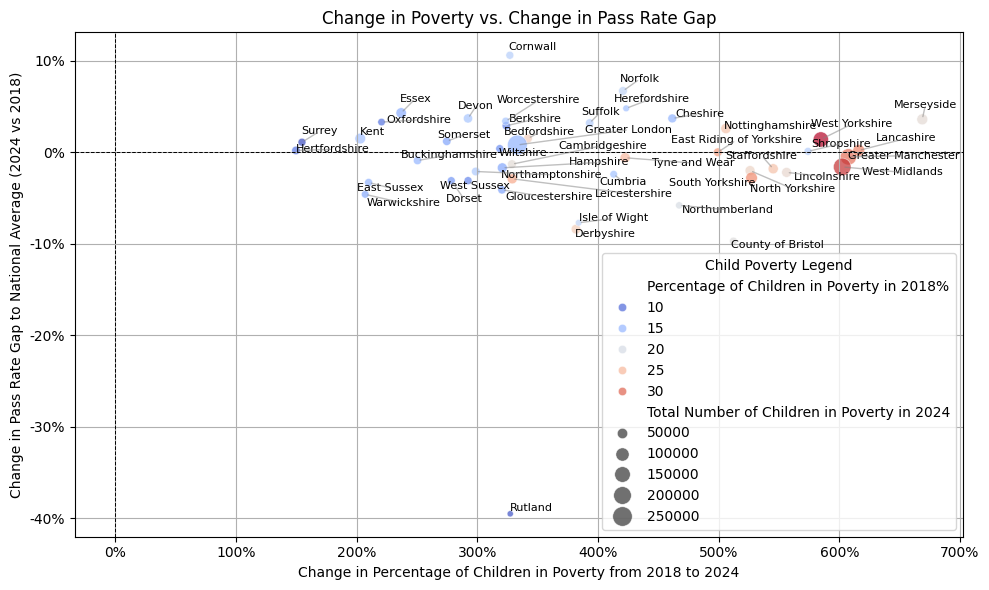

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=merged_GCSE_poverty_2018_2024,
    x='Change in Child Poverty from 2018 to 2024',
    y='Change in Difference from National Average from 2018 to 2024',
    size='Total Number of Children in Poverty in 2024',
    hue='Percentage of Children in Poverty in 2018',
    palette='coolwarm',
    sizes=(20, 200),
    alpha=0.7
)

# Create label objects
texts = []
for i, row in merged_GCSE_poverty_2018_2024.iterrows():
    texts.append(
        plt.text(
            row['Change in Child Poverty from 2018 to 2024'],
            row['Change in Difference from National Average from 2018 to 2024'],
            row['GCSE_County'],
            fontsize=8
        )
    )

# Adjust labels with a minimum distance from points to avoid overlap with bubbles
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),
    force_text=0.2,        # Allow text to move further from points
    force_points=0.4,      # Allow points to move slightly to make space
    only_move={'points': 'y', 'text': 'xy'},  # Move the labels freely in both directions
    lim=100,               # Increase iterations to improve placement
    add_textprops={'verticalalignment': 'bottom', 'horizontalalignment': 'left'},  # Adjust label alignment
    expand_points=(1.5, 1.5),  # Expand the area in which points can move, giving them more space
)

# Add percentage symbol to y-axis labels
def percentage(x, pos):
    return f'{x :.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage))

# Add percentage symbol to x-axis labels if required
plt.gca().xaxis.set_major_formatter(FuncFormatter(percentage))

# Modify the legend labels to add percentage symbol only for "Percentage of Children in Poverty in 2018"
handles, labels = plt.gca().get_legend_handles_labels()

# Update the labels selectively to add "%" for percentage values
new_labels = []
for label in labels:
    if "Percentage of Children in Poverty in 2018" in label:
        new_labels.append(f'{label}%')
    else:
        new_labels.append(label)

# Set the modified legend with new labels
plt.legend(handles, new_labels, title='Child Poverty Legend')

plt.title('Change in Poverty vs. Change in Pass Rate Gap')
plt.xlabel('Change in Percentage of Children in Poverty from 2018 to 2024')
plt.ylabel('Change in Pass Rate Gap to National Average (2024 vs 2018)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# save the image 
plt.savefig('output/figures/2024_Child_Poverty_vs_Change_in_Pass_Rate_from_National_average.png', dpi=300)

<Figure size 640x480 with 0 Axes>

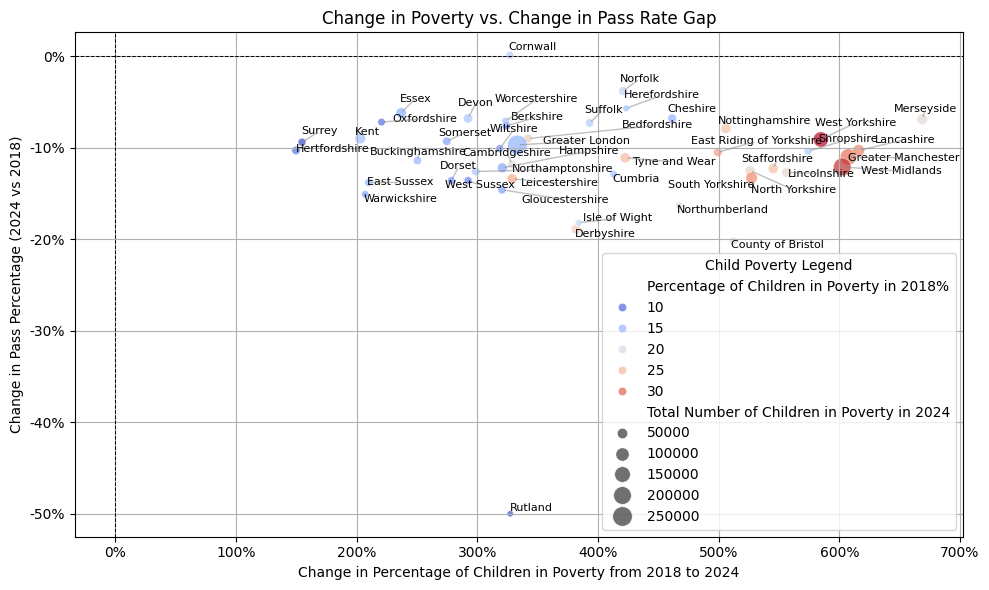

<Figure size 640x480 with 0 Axes>

In [17]:
## Change passing percentage 
   
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from adjustText import adjust_text

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(
    data=merged_GCSE_poverty_2018_2024,
    x='Change in Child Poverty from 2018 to 2024',
    y='Change in Pass Percentage from 2018 to 2024',
    size='Total Number of Children in Poverty in 2024',
    hue='Percentage of Children in Poverty in 2018',
    palette='coolwarm',
    sizes=(20, 200),
    alpha=0.7
)

# Create label objects
texts = []
for i, row in merged_GCSE_poverty_2018_2024.iterrows():
    texts.append(
        plt.text(
            row['Change in Child Poverty from 2018 to 2024'],
            row['Change in Pass Percentage from 2018 to 2024'],
            row['GCSE_County'],
            fontsize=8
        )
    )

# Adjust labels with a minimum distance from points to avoid overlap with bubbles
adjust_text(
    texts,
    arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5),
    force_text=0.2,        # Allow text to move further from points
    force_points=0.4,      # Allow points to move slightly to make space
    only_move={'points': 'y', 'text': 'xy'},  # Move the labels freely in both directions
    lim=100,               # Increase iterations to improve placement
    add_textprops={'verticalalignment': 'bottom', 'horizontalalignment': 'left'},  # Adjust label alignment
    expand_points=(1.5, 1.5),  # Expand the area in which points can move, giving them more space
)

# Add percentage symbol to y-axis labels
def percentage(x, pos):
    return f'{x :.0f}%'

plt.gca().yaxis.set_major_formatter(FuncFormatter(percentage))

# Add percentage symbol to x-axis labels if required
plt.gca().xaxis.set_major_formatter(FuncFormatter(percentage))

# Modify the legend labels to add percentage symbol only for "Percentage of Children in Poverty in 2018"
handles, labels = plt.gca().get_legend_handles_labels()

# Update the labels selectively to add "%" for percentage values
new_labels = []
for label in labels:
    if "Percentage of Children in Poverty in 2018" in label:
        new_labels.append(f'{label}%')
    else:
        new_labels.append(label)

# Set the modified legend with new labels
plt.legend(handles, new_labels, title='Child Poverty Legend')

plt.title('Change in Poverty vs. Change in Pass Rate Gap')
plt.xlabel('Change in Percentage of Children in Poverty from 2018 to 2024')
plt.ylabel('Change in Pass Percentage (2024 vs 2018)')
plt.axhline(0, color='black', linestyle='--', linewidth=0.7)
plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig('output/figures/2024_Child_Poverty_vs_Passrate_change.png', dpi=300)
